# Gnocis - Figures for manuscript
Bjørn André Bredesen, 2020

## Data sources
 * ModENCODE: http://www.modencode.org/
    - Citation: https://www.nature.com/articles/459927a
 * Ensembl: ftp://ftp.ensembl.org/pub/release-100/gtf/drosophila_melanogaster/
    - Citation: https://doi.org/10.1093/nar/gkx1098
 * FlyBase: https://flybase.org/
    - Citation: https://academic.oup.com/nar/article/41/D1/D751/1051942
 * Kahn *et al.* 2014: https://doi.org/10.1371/journal.pgen.1004495.s010
    - Citation: https://doi.org/10.1371/journal.pgen.1004495

### Data preparation and preliminary analysis

In [1]:
import gnocis as nc # Load Gnocis
nc.setSeed(12345) # Set random seed
nc.setNCores(12) # Enable multi-core processing

In [2]:
Dmel = nc.genome('D. melanogaster R5')\
    .streamFASTAGZ('DmelR5.fasta.gz')\
    .loadEnsemblAnnotationGTFGZ('./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz')

In [3]:
# We exclude PREs within 100kb of the invected gene for validation
invectedProximal = Dmel.gene('inv').region.singleton().recenter(100000)

In [4]:
# Load Kahn et al. PREs
Kahn2014Rgn = nc.loadGFF('Kahn2014.GFF')
# Extract PRE sequences from genome
Kahn2014Seq = Kahn2014Rgn.nonOverlap(invectedProximal).recenter(3000).extract(Dmel)

In [5]:
# Generate dummy PREs
MCPRE = nc.MarkovChain(trainingSequences = Kahn2014Seq, degree = 4)
DummyPREs = MCPRE.generateSet(n = 100 * len(Kahn2014Seq), length = len(Kahn2014Seq[0]))

In [6]:
# Generate dummy genomic
MCGenome = nc.MarkovChain(trainingSequences = Dmel, degree = 4)
DummyGenomic = MCGenome.generateSet(n = 100 * len(Kahn2014Seq), length = len(Kahn2014Seq[0]))

In [7]:
# Extract CDS, concatenate, and get non-overlapping 3kb fragments
CDSSeq = Dmel.getCDS().flatten().extract(Dmel)
CDSFragments = nc.sequence('CDS', ''.join(s.seq for s in CDSSeq)).windows(3000, 3000)

In [8]:
# Load PcG biomarkers
PcG = nc.biomarkers('PcG', [
    nc.loadGFFGZ('Pc.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('Psc.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('dRING.gff3.gz').deltaResize(1000),
    nc.loadGFFGZ('H3K27me3.gff3.gz'),
])

In [9]:
gwWin = Dmel.windowRegions(size = 1000, step = 100)

In [10]:
# Extract highly biomarker-enriched (HBME) regions
HBMERgn = PcG.HBMEs(gwWin, threshold = 3)

In [11]:
# Extract lowly biomarker-enriched (LBME) regions
LBMERgn = PcG.LBMEs(gwWin, threshold = 1).filter('', lambda r: len(r) >= 3000)
LBMESeq = LBMERgn.extract(Dmel).windows(3000, 3000)

In [12]:
LBMESeq.printStatistics()

Sequence set statistics - Regions set: Windows (Window size: 1000 bp; step size: 100 bp) (PcG LBME) () - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> (windows - size: 3000 bp; step: 3000 bp)
 - Sequences: 51233
 - Mean length: 3000.00 nt (min.: 3000 nt - max.: 3000 nt)
 - Total length: 153699000 nt


In [13]:
LBMERgn.overlap(Kahn2014Rgn)

0,3L,627600,636199,+,8600
1,3L,13496200,13660499,+,164300
2,3R,13910100,13934299,+,24200


In [14]:
Kahn2014Rgn

0,2L,5290,6289,+,1000
1,2L,594635,595634,+,1000
2,2L,1643905,1644904,+,1000
3,2L,1972530,1973529,+,1000
4,2L,2448155,2449154,+,1000
5,2L,2450980,2451979,+,1000
6,2L,2454212,2455211,+,1000
7,2L,3538793,3539792,+,1000
8,2L,3544970,3545969,+,1000
9,2L,3606249,3607248,+,1000
...,...,...,...,...,...


In [15]:
motifs = nc.motifs('Ringrose et al. 2003 + GTGT', [
    nc.IUPACMotif('En', 'GSNMACGCCCC', 1),
    nc.IUPACMotif('G10', 'GAGAGAGAGA', 1),
    nc.IUPACMotif('GAF', 'GAGAG', 0),
    nc.IUPACMotif('PF', 'GCCATHWY', 0),
    nc.IUPACMotif('PM', 'CNGCCATNDNND', 0),
    nc.IUPACMotif('PS', 'GCCAT', 0),
    nc.IUPACMotif('Z', 'YGAGYG', 0),
    nc.IUPACMotif('GTGT', 'GTGT', 0)
])

In [16]:
# Construct a distance-thresholded motif pair feature set, and
# output enrichment statistics
motifs.pairFreq(220) \
    .diffsummary(Kahn2014Seq, DummyPREs) \
    .sort('KLD(A||B)', ascending = False)

8,"pairFreq(G10, G10, 220)",1.9360,0.0242,3622.9675,509.8565,2.0761,0.5513
26,"pairFreq(PM, PM, 220)",0.0572,0.0390,3.7957,354.1220,1.7732,43.8795
27,"pairFreq(PM, PS, 220)",0.5825,0.4453,119.0415,8272.0965,1.6278,32.1241
28,"pairFreq(PM, Z, 220)",0.5185,0.4443,102.5432,6842.8516,1.6078,30.7654
30,"pairFreq(PS, PS, 220)",1.5337,1.2758,439.4978,27113.9999,1.5692,28.2856
23,"pairFreq(PF, PS, 220)",0.8350,0.6524,231.2772,13820.9931,1.5535,27.3346
29,"pairFreq(PM, GTGT, 220)",1.9007,1.7343,1123.4910,65997.9138,1.5451,26.8352
31,"pairFreq(PS, Z, 220)",3.0168,2.5375,932.1661,52759.2298,1.5268,25.7814
25,"pairFreq(PF, GTGT, 220)",2.7643,2.5316,1820.1122,96513.2983,1.4948,24.0276
32,"pairFreq(PS, GTGT, 220)",10.0034,9.8808,8679.7755,449524.6754,1.4833,23.4214
...,...,...,...,...,...,...,...


In [17]:
# Construct a distance-thresholded motif pair feature set, and
# output enrichment statistics
motifs.pairFreq(220) \
    .summary(Kahn2014Seq) \
    .sort('Mean', ascending = False)

35,"pairFreq(G... GTGT, 220)",Number,30.4714,253487.7823,35.8712
20,"pairFreq(GAF, GTGT, 220)",Number,20.2744,101580.9792,22.7077
34,"pairFreq(Z, GTGT, 220)",Number,13.1902,22160.5011,10.6061
32,"pairFreq(PS, GTGT, 220)",Number,10.0034,8679.7755,6.6378
14,"pairFreq(G10, GTGT, 220)",Number,8.8906,41993.2957,14.6001
15,"pairFreq(GAF, GAF, 220)",Number,7.7727,21290.5505,10.3959
9,"pairFreq(G10, GAF, 220)",Number,7.6515,33920.7323,13.1220
19,"pairFreq(GAF, Z, 220)",Number,6.9495,11361.9394,7.5944
18,"pairFreq(GAF, PS, 220)",Number,4.1599,2919.4910,3.8496
13,"pairFreq(G10, Z, 220)",Number,3.0606,5193.9394,5.1347
...,...,...,...,...,...


In [18]:
# Construct a distance-thresholded motif pair feature set, and
# output enrichment statistics
motifs.pairFreq(220).filter([ 0, 1, 2, 3 ]) \
    .summary(Kahn2014Seq) \
    .sort('Mean', ascending = False)

2,"pairFreq(En, GAF, 220)",Number,0.5522,377.6274,1.3845
1,"pairFreq(En, G10, 220)",Number,0.2391,184.9068,0.9688
3,"pairFreq(En, PF, 220)",Number,0.0943,10.6846,0.2329
0,"pairFreq(En, En, 220)",Number,0.0253,2.4293,0.1110


### Cross-validation

In [19]:
# We want to use three classes of negatives for training, so we add labels for these
labelDummyGenomic = nc.sequenceLabel('Dummy genomic', -1)
labelDummyPRE = nc.sequenceLabel('Dummy PRE', -2)
labelCDS = nc.sequenceLabel('CDS', -3)
# We use these labels to construct our training set, to enable multiclass learning
trainingSet = Kahn2014Seq.label(nc.positive)\
    + DummyGenomic.label(labelDummyGenomic)\
    + DummyPREs.label(labelDummyPRE)\
    + CDSFragments.label(labelCDS)

In [20]:
# PyPREdictor
motifs = nc.motifs('Ringrose et al. 2003 + GTGT', [
    nc.IUPACMotif('En', 'GSNMACGCCCC', 1),
    nc.IUPACMotif('G10', 'GAGAGAGAGA', 1),
    nc.IUPACMotif('GAF', 'GAGAG', 0),
    nc.IUPACMotif('PF', 'GCCATHWY', 0),
    nc.IUPACMotif('PM', 'CNGCCATNDNND', 0),
    nc.IUPACMotif('PS', 'GCCAT', 0),
    nc.IUPACMotif('Z', 'YGAGYG', 0),
    nc.IUPACMotif('GTGT', 'GTGT', 0)
])
PyPREdictor = motifs\
        .pairFreq(distCut = 219)\
        .model(nc.logOdds(labelPositive = nc.positive, labelNegative = labelDummyPRE))\
        .sequenceModel(name = 'PyPREdictor (M2003+GTGT)',
                       windowSize = 500, windowStep = 250)

# Quadratic 5-spectrum kernel SVM
import gnocis.sklearnCUDAModels as sklcunc
spectrumSVM = nc.kSpectrum(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (quadratic, 5-spectrum)')

# Quadratic 5-spectrum mismatch kernel SVM
mismatchSVM = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'SVM (quadratic, 5-spectrum mismatch)')

# CNN
import gnocis.tfModels as tfnc
tfnc.setSeed(12345)
CNN = tfnc.sequenceModelMultiCNN(
            name = 'Convolutional Neural Network',
            windowSize = 500, windowStep = 250,
            nConv = 15, convLen = 10,
            epochs = 250,
            targetLabel = nc.positive,
            labels = [ nc.positive, labelDummyPRE, labelDummyGenomic, labelCDS ] )

In [21]:
# Optional: SVM-MOCCA - requires separate installation
from gnocis.MOCCAModels import sequenceModelSVMMOCCA
SVMMOCCA = sequenceModelSVMMOCCA('SVM-MOCCA', MOCCAPath = 'INSERT_MOCCA_PATH_HERE',
    motifs = motifs, windowSize = 3000, windowStep = 1000, kDegree = 2,
    labelsPositive = [ nc.positive ], labelsNegative = [ labelDummyGenomic, labelDummyPRE, labelCDS ])

#### PREs versus dummy-PREs

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<Dm

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS windows(3000/3000)>   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172>>                             544                              6262         20                     100.0              0.6875
Evaluation statistics
Rows: 5
Columns: 3
                       Model            PRC AUC            ROC AUC
0   PyPREdictor (M2003+GTGT)   36.75 +/- 2.04 %   75.75 +/- 1.33 %
1   SVM (quadr...5-spectrum)    3.57
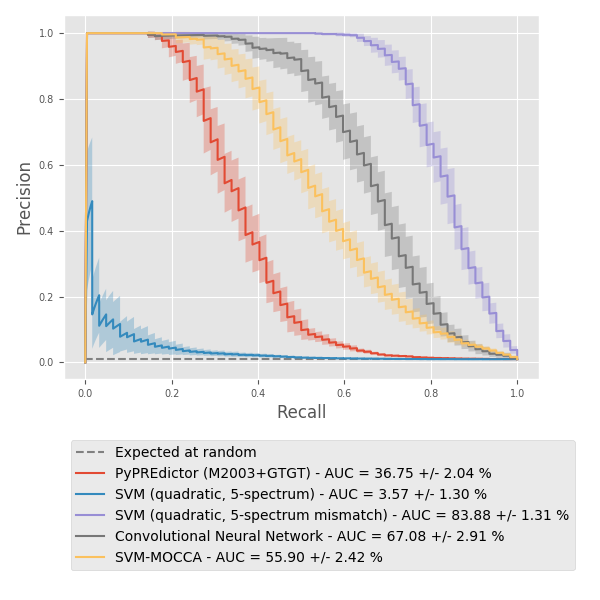
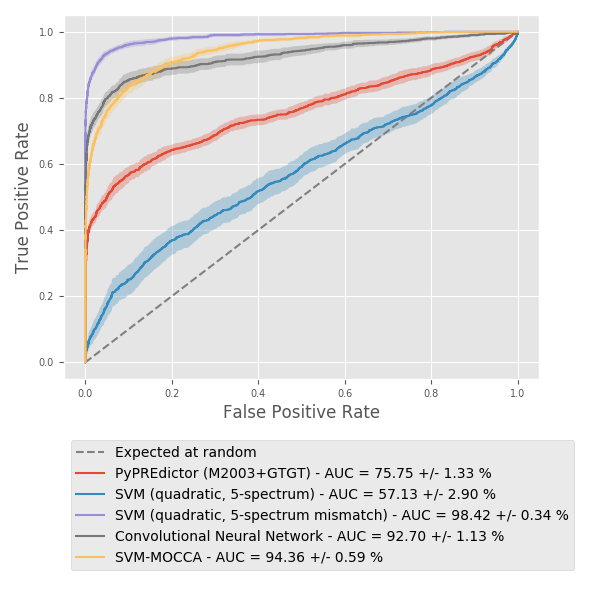

In [22]:
# Cross-validate: PREs versus dummy-PREs
cvPREvsDummyPRE = nc.crossvalidate([
        PyPREdictor,
        spectrumSVM,
        mismatchSVM,
        CNN,
        SVMMOCCA
    ],
    trainingSet = trainingSet,
    validationSet = Kahn2014Seq.label(nc.positive) + DummyPREs.label(nc.negative),
    ratioTrainTest = 0.6875, # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
    ratioNegPos = 100.)
cvPREvsDummyPRE

In [23]:
cvPREvsDummyPRE.plotPRC(outpath = './fig3APRCPREsVsDummyPREs.pdf')

#### PREs versus coding sequences

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<Dm

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Training set:                                                                                                                                                                                                                                                                                              Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS windows(3000/3000)>   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + CDS windows(3000/3000)>                             544                              6262         20                     100.0              0.6875
Evaluation statistics
Rows: 5
Columns: 3
                       Model            PRC AUC             ROC AUC
0   PyPREdictor (M2003+GTGT)   61.90 +/- 1.80 %    95.51 +/- 0.69 %
1   SVM (quadr...5-spectrum)    6.74 +/- 3.40 %   58.86 +/- 14.21 %
2   SVM (quadr...m mismatch)    1.45 +/- 0.19 %    55.92 +/- 2.58 %
3   Convolutio...ral Network   65.74 +/- 3.58 %    98.98 +/- 0.17 %
4                  SVM-MOCCA   73.56 +/- 2.22 %    98.35 +/- 0.31 %
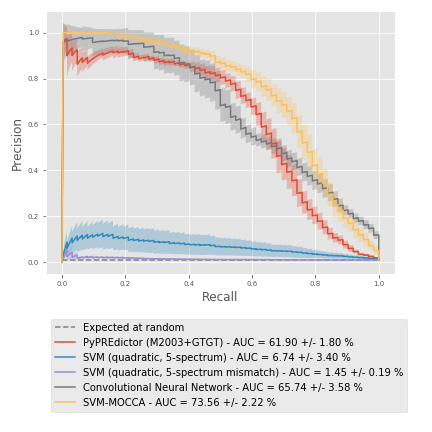
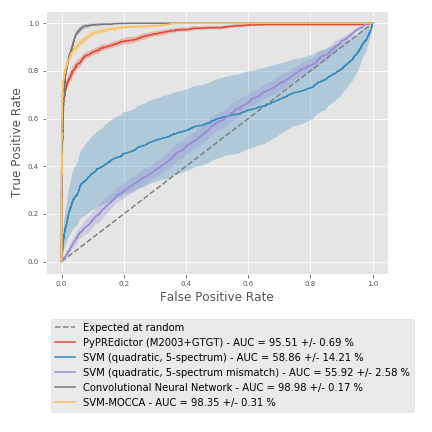

In [24]:
# Cross-validate
valSet = Kahn2014Seq.label(nc.positive) + CDSFragments.label(nc.negative)
cvPREvsCDS = nc.crossvalidate(cvPREvsDummyPRE.models,
    trainingSet = trainingSet,
    validationSet = valSet,
    ratioTrainTest = 0.6875) # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
cvPREvsCDS

In [25]:
cvPREvsCDS.plotPRC(outpath = './fig3BPRCPREsVsCDS.pdf')

#### PREs versus dummy genomic

Cross-validation
 - Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<Dm

Cross-validation

Configuration
Rows: 1
Columns: 7
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Training set:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Validation set:   Training sequences per repeat   Validation sequences per repeat   Repeats:   Negatives per positive:   Train/test ratio:
0   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 831769172> + CDS windows(3000/3000)>   Sequence list<Regions set: GFF file: Kahn2014.GFF not overlapping with Region<2R:7361970..7394687 (+) (Score: 0.000000; Source: FlyBase; Feature: gene)> (recentered - 100000 bp) (recentered - 3000 bp) - from sequence stream: FASTA sequence stream<DmelR5.fasta.gz> + Generated set <Sequences: 19800; Length each: 3000; Model: Markov Chain<Degree: 4; Pseudocounts: 1; Add reverse complements: Yes; Training set: Genome<D. melanogaster R5; annotation: ./ensembl_Drosophila_melanogaster.BDGP5.77.gtf.gz; sequences: FASTA sequence stream<DmelR5.fasta.gz>>>; Seed: 2922854590>>                             544                              6262         20                     100.0              0.6875
Evaluation statistics
Rows: 5
Columns: 3
                       Model            PRC AUC            ROC AUC
0   PyPREdictor (M2003+GTGT)   62.88 +/- 2.27 %   92.91 +/- 0.75 %
1   SVM (quadr...5-spectrum)    4.89 +/- 2.40 %   58.93 +/- 4.35 %
2   SVM (quadr...m mismatch)   82.15 +/- 1.67 %   97.97 +/- 0.36 %
3   Convolutio...ral Network   65.28 +/- 2.08 %   90.90 +/- 1.52 %
4                  SVM-MOCCA   83.12 +/- 2.19 %   98.52 +/- 0.33 %
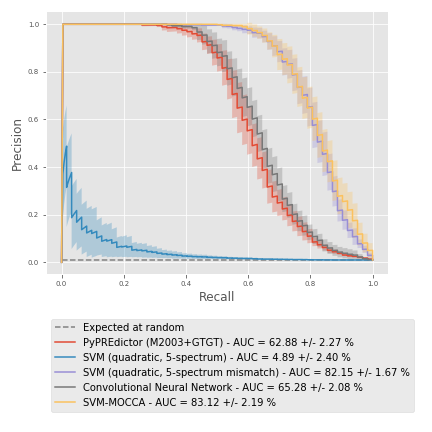
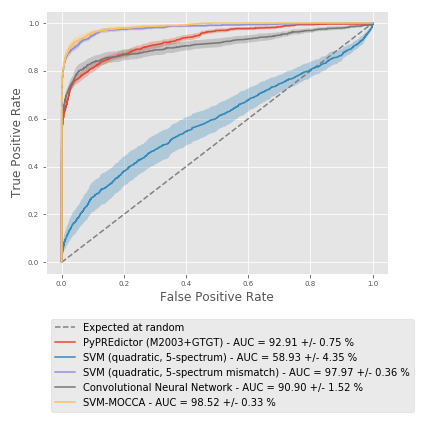

In [26]:
# Optional
# Cross-validate
valSet = Kahn2014Seq.label(nc.positive) + DummyGenomic.label(nc.negative)
cvPREvsDummyGenomic = nc.crossvalidate(cvPREvsDummyPRE.models,
    trainingSet = trainingSet,
    validationSet = valSet,
    ratioTrainTest = 0.6875) # This ratio is chosen in order to give the same ratio as in Bredesen et al. 2019,
                             # for generalization comparable with Figure 1C
cvPREvsDummyGenomic

In [27]:
cvPREvsDummyGenomic.plotPRC(outpath = './figExtraPRCPREsVsDummyGenomic.pdf')

### SVM runtime benchmarks

In [28]:
import gnocis.sklearnModels as sklnc
import time
import datetime

mismatchSVM_SingleCPU = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'Single')
mismatchSVM_SingleCPU = mismatchSVM_SingleCPU.getTrainer()(cvPREvsDummyGenomic.cvtrain[0])
mismatchSVM_SingleCPU.enableMultiprocessing = False

mismatchSVM_MultiCPU = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklnc.SVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'Multiprocessing')
mismatchSVM_MultiCPU = mismatchSVM_MultiCPU.getTrainer()(cvPREvsDummyGenomic.cvtrain[0])

mismatchSVM_CUDA = nc.kSpectrumMM(5)\
      .window(size = 500, step = 250)\
      .scale()\
      .model(sklcunc.CUDASVM(kDegree = 2, C = 1, labelPositive = nc.positive, labelNegative = labelDummyPRE))\
      .sequenceModel(name = 'CUDA')
mismatchSVM_CUDA = mismatchSVM_CUDA.getTrainer()(cvPREvsDummyGenomic.cvtrain[0])

def timerun(func):
    t0 = time.time()
    func()
    return str(datetime.timedelta(seconds = time.time() - t0))

nc.nctable('Running times', [
    {
        'Name': model.name,
        'Time': str(timerun( lambda: model.getSequenceScores(DummyGenomic) ))
    }
    for model in [
        mismatchSVM_SingleCPU,
        mismatchSVM_MultiCPU,
        mismatchSVM_CUDA,
    ]
])

0,Single,0:11:25.223450
1,Multiprocessing,0:06:10.507558
2,CUDA,0:01:28.281257


In [29]:
len(DummyGenomic)

19800

### Genome-wide prediction

In [30]:
rep = 0
trainedModels = [
    mdl.getTrainer()(cvPREvsDummyPRE.cvtrain[rep])
    for mdl in cvPREvsDummyPRE.models
    if mdl.name != 'SVM-MOCCA' # Exclude SVM-MOCCA, for which we use core-PRE prediction
]

In [31]:
vpos = cvPREvsDummyPRE.cvval[rep].withLabel(nc.positive)
for mdl in trainedModels:
    print('Calibrating model: %s'%mdl.name)
    mdl.calibrateGenomewidePrecision(positives = vpos,
                                    genome = Dmel,
                                    factor = 1. - 0.6875,
                                    precision = 0.8,
                                    bgModelOrder = 4)

Calibrating model: PyPREdictor (M2003+GTGT)
Calibrating model: SVM (quadratic, 5-spectrum)
Calibrating model: SVM (quadratic, 5-spectrum mismatch)
Calibrating model: Convolutional Neural Network


In [32]:
modelPredictions = []

for mdl in trainedModels:
    print('Predicting with model: %s'%mdl.name)
    modelPredictions.append( mdl.predict(Dmel.sequences) )

Predicting with model: PyPREdictor (M2003+GTGT)
Predicting with model: SVM (quadratic, 5-spectrum)
Predicting with model: SVM (quadratic, 5-spectrum mismatch)
Predicting with model: Convolutional Neural Network


In [33]:
# Optional: Add core-PRE predictions made by SVM-MOCCA
SVMMOCCA = cvPREvsDummyPRE.models[-1].getTrainer()(cvPREvsDummyPRE.cvtrain[rep])
modelPredictions += [
    SVMMOCCA.predictCore(
        vpos = vpos,
        genome = Dmel,
        factor = 1. - 0.6875,
        precision = 0.8,
        bgModelOrder = 4
    )
]

In [34]:
modelPredictions += [
    nc.loadGFF(SVMMOCCA.tmpPath + 'pred.gff')
]


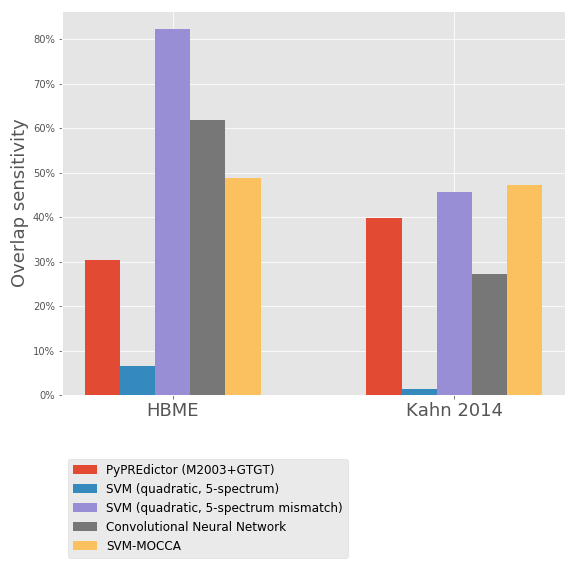

In [35]:
nc.overlapSensitivityBarplot(regionSets = [
        HBMERgn.rename('HBME'),
        Kahn2014Rgn.rename('Kahn 2014'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        if mdl.name != 'SVM-MOCCA' else pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ])

In [36]:
nc.overlapSensitivityBarplot(regionSets = [
        HBMERgn.rename('HBME'),
        Kahn2014Rgn.rename('Kahn 2014'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        if mdl.name != 'SVM-MOCCA' else pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ],
    outpath = "fig4AOverlapSensitivity.pdf")


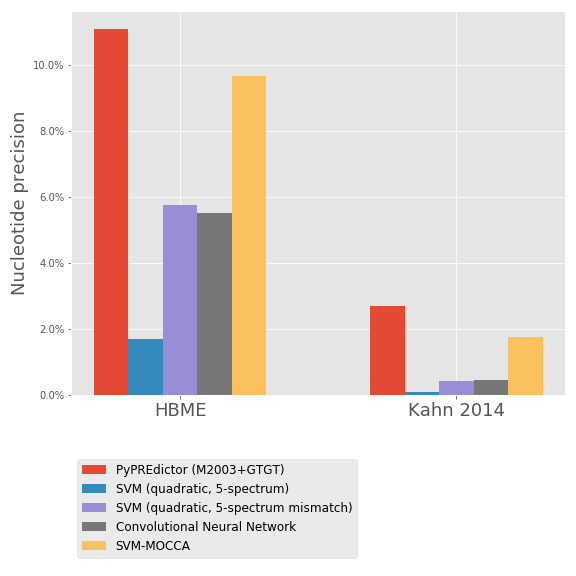

In [37]:
nc.nucleotidePrecisionBarplot(regionSets = [
        HBMERgn.deltaResize(1000).flatten().rename('HBME'),
        Kahn2014Rgn.deltaResize(1000).flatten().rename('Kahn 2014'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        if mdl.name != 'SVM-MOCCA' else pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ])

In [38]:
nc.nucleotidePrecisionBarplot(regionSets = [
        HBMERgn.deltaResize(1000).flatten().rename('HBME'),
        Kahn2014Rgn.deltaResize(1000).flatten().rename('Kahn 2014'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        if mdl.name != 'SVM-MOCCA' else pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ],
    outpath = "fig4BNucleotidePrecision.pdf")


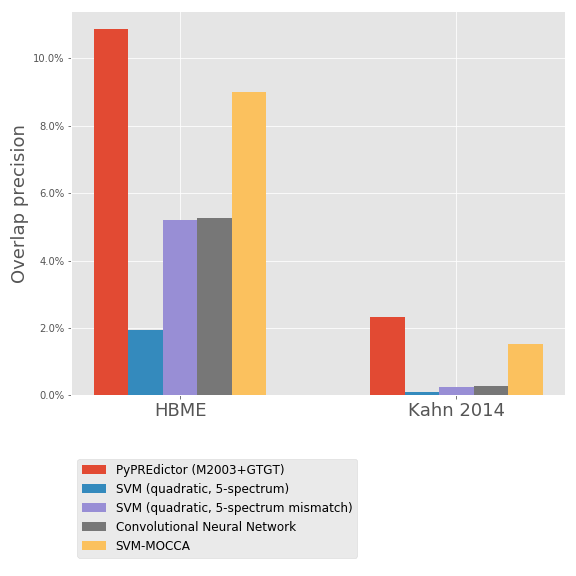

In [39]:
nc.overlapPrecisionBarplot(regionSets = [
        HBMERgn.rename('HBME'),
        Kahn2014Rgn.rename('Kahn 2014'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        if mdl.name != 'SVM-MOCCA' else pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ])

In [40]:
nc.overlapPrecisionBarplot(regionSets = [
        HBMERgn.rename('HBME'),
        Kahn2014Rgn.rename('Kahn 2014'),
    ], predictionSets = [
        pred.regions().rename(mdl.name)
        if mdl.name != 'SVM-MOCCA' else pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ],
    outpath = "figExtraOverlapPrecision.pdf")


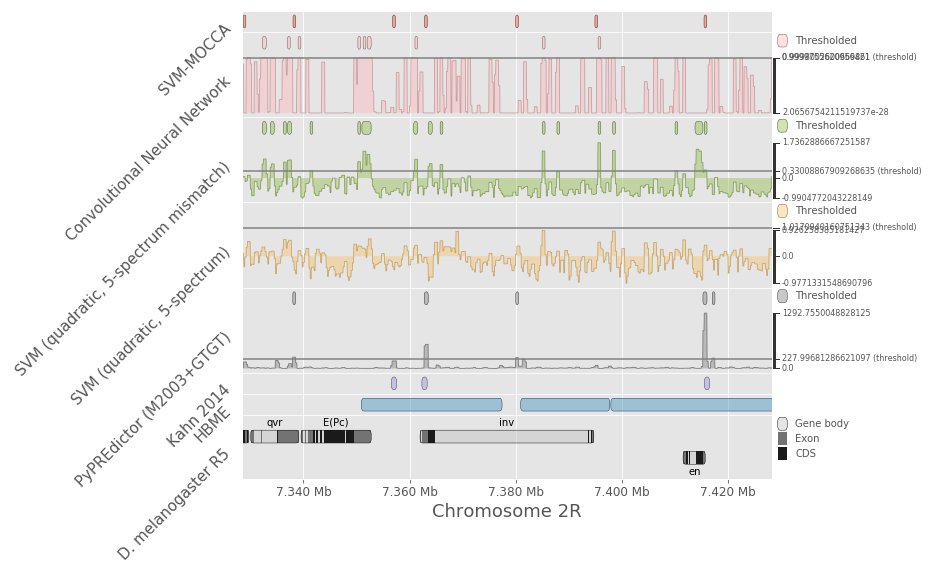

In [41]:
nc.plotGenomeTracks(
    [
        Dmel,
        HBMERgn.rename('HBME'),
        Kahn2014Rgn.rename('Kahn 2014'),
    ] + [
        pred.rename(mdl.name)
        for mdl, pred in zip(cvPREvsDummyPRE.models, modelPredictions)
    ],
    invectedProximal[0].seq,
    invectedProximal[0].start,
    invectedProximal[0].end)

In [42]:
nc.plotGenomeTracks(
    [
        Dmel,
        HBMERgn.rename('HBME'),
        Kahn2014Rgn.rename('Kahn 2014'),
    ] + [
        pred.rename(mdl.name)
        for mdl, pred in zip(trainedModels, modelPredictions)
    ],
    invectedProximal[0].seq,
    invectedProximal[0].start,
    invectedProximal[0].end,
    outpath = "fig5InvectedLocus.pdf")